## Replicating Vision Transformer on FoodVision-Mini

This notebook implements the following:

- Implements the Vision Transformer (ViT) from scratch in Python  
- Trains the ViT on the FoodVision-Mini dataset  
- Applies transfer learning to fine-tune the ViT on FoodVision-Mini  
- Fine-tunes an EfficientNet-B2 model on the same dataset  
- Compares the performance of the two models


### Setup

In [2]:
import torch
from torch import nn
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

from src.data.dataloader import create_dataloader
from src.data.transforms import get_basic_transforms, get_imagenet_transforms
from src.utils import set_seed, dataset_summary, display_random_images, accuracy_fn, plot_loss_curves, plot_model_comparison
from src.train import train
from src.models.vit import ViT, create_ViT_model
from src.models.efficientb2 import create_effnet_b2
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Setting seed for deterministic behaviour
set_seed(42)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

### Data loading and Exploration

In [4]:
# Setup training and validation directory 

PROJECT_ROOT = Path(".").resolve().parent
DATA_DIR = PROJECT_ROOT / "data" / "food-101-tiny"

train_dir = DATA_DIR / "train"
val_dir = DATA_DIR / "valid"

In [5]:
dataset_summary(train_dir)

DATASET SUMMARY
----------------------------
Number of classes : 10
Total train images : 1500

Images per class:
  apple_pie       -> 150
  bibimbap        -> 150
  cannoli         -> 150
  edamame         -> 150
  falafel         -> 150
  french_toast    -> 150
  ice_cream       -> 150
  ramen           -> 150
  sushi           -> 150
  tiramisu        -> 150
----------------------------


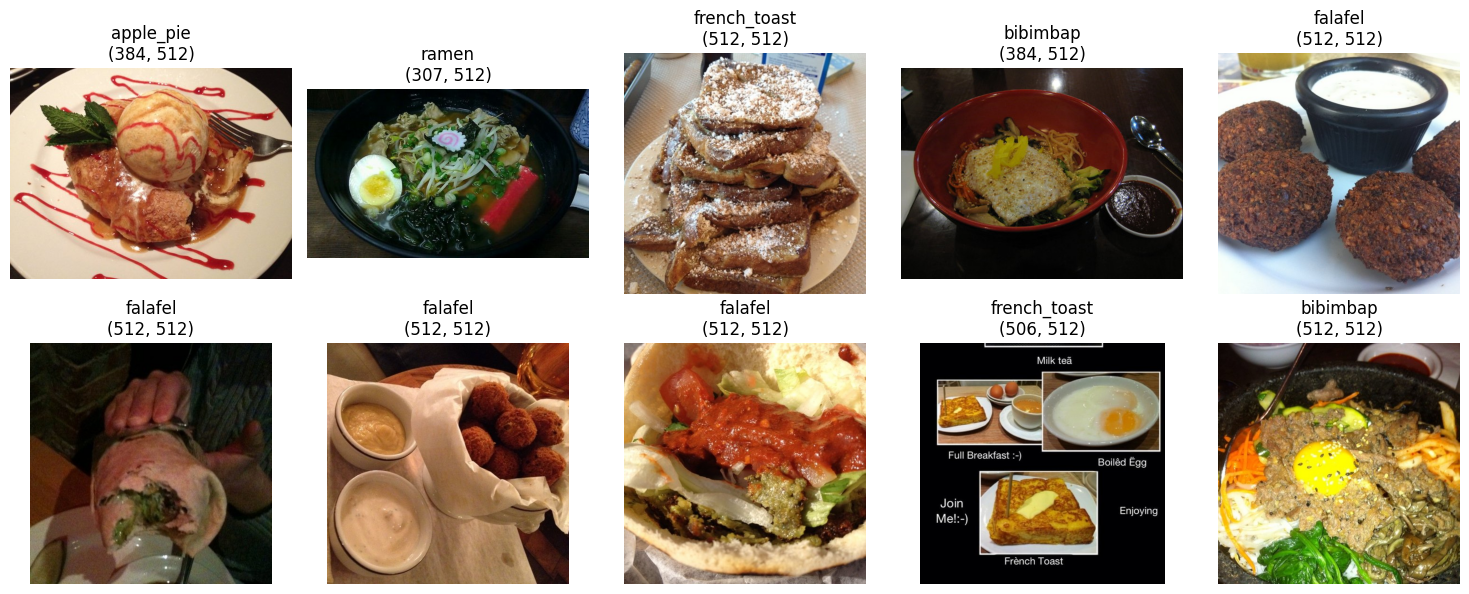

In [6]:
display_random_images(train_dir)

### Setting up dataloaders

### Vision Transformer (ViT) Model Setup

In [7]:
vit_from_scratch = ViT().to(device)

### Raw Training

In [ ]:
BATCH_SIZE = 4 ### Memory constraints
EPOCHS = 8
train_tf, val_tf = get_basic_transforms()

dataloaders = create_dataloader(train_dir,
                                train_tf,
                                val_tf,
                                val_dir,
                                test_dir=None,
                                batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(vit_from_scratch.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
accuracy_fn = accuracy_fn


vit_training_from_scratch_results = train(vit_from_scratch,
                             dataloaders.train,
                             dataloaders.val,
                             optimizer,
                             loss_fn,
                              accuracy_fn,
                             device,
                             EPOCHS,
                             model_name="ViT_from_scratch"
                             )

Figure saved to ../figures/vit_from_scratch.png


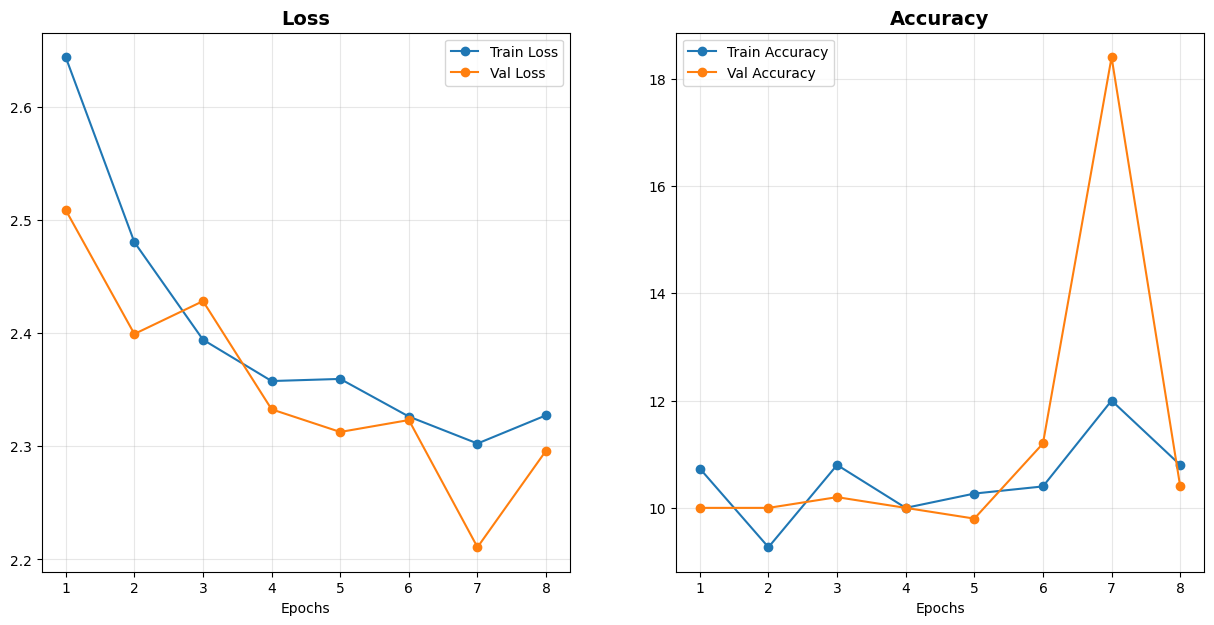

In [9]:
plot_loss_curves(vit_training_from_scratch_results, 
                 save_path="../figures/vit_from_scratch.png")

### Transfer Learning --- ViT

In [10]:
# Initialise a Vision Transformer 
vit_transfer_learning = create_ViT_model()

ViT transfer learning model initialised


In [ ]:
BATCH_SIZE = 32
EPOCHS = 12
train_tf, val_tf = get_imagenet_transforms()

dataloaders = create_dataloader(train_dir,
                                train_tf,
                                val_tf,
                                val_dir,
                                test_dir=None,
                                batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(vit_transfer_learning.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
accuracy_fn = accuracy_fn

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=1e-5
)

vit_transfer_learning_training_results = train(vit_transfer_learning,
                             dataloaders.train,
                             dataloaders.val,
                             optimizer,
                             loss_fn,
                             accuracy_fn,
                             device,
                             EPOCHS,
                             model_name="ViT_transfer_learning",
                             scheduler=scheduler
                             )

Figure saved to ../figures/vit_transfer_learning.png


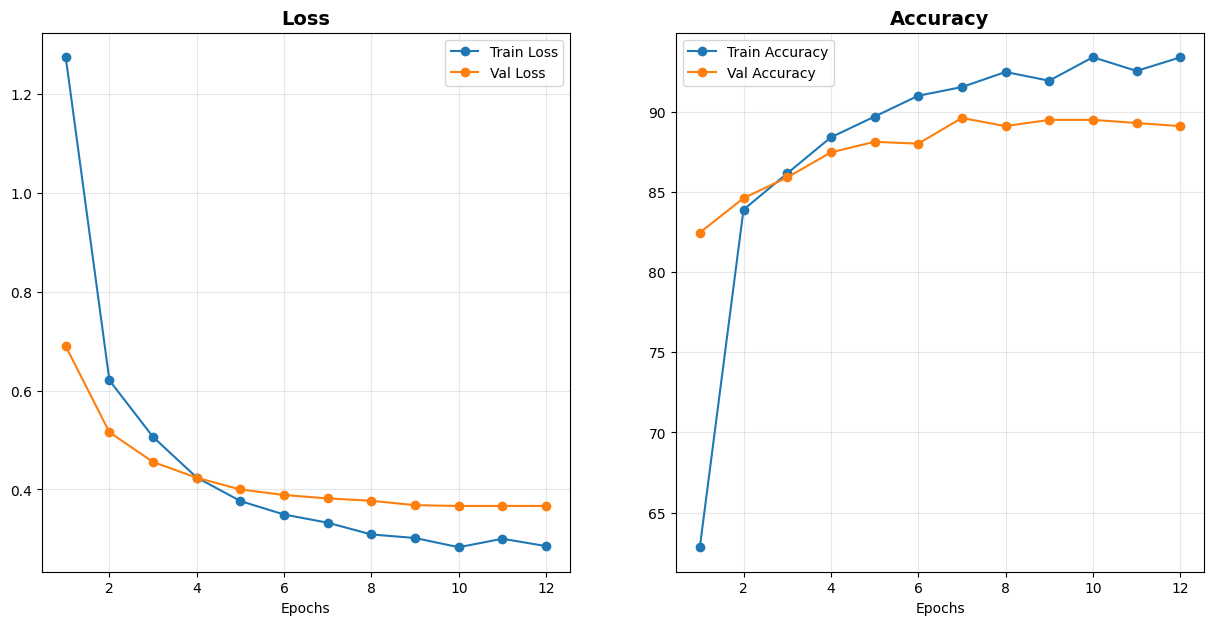

In [12]:
plot_loss_curves(vit_transfer_learning_training_results, 
                 save_path="../figures/vit_transfer_learning.png")

### EfficientNet-B2 Transfer Learning

In [13]:
efficient_b2_model = create_effnet_b2()

EfficientNetB2 transfer learning model initialised


In [ ]:
BATCH_SIZE = 32
EPOCHS = 12

train_tf, val_tf = get_imagenet_transforms()

dataloaders = create_dataloader(train_dir,
                                train_tf,
                                val_tf,
                                val_dir,
                                test_dir=None,
                                batch_size=BATCH_SIZE)



optimizer = torch.optim.Adam(efficient_b2_model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
accuracy_fn = accuracy_fn


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2
)

efficientb2_transfer_learning_training_results = train(efficient_b2_model,
                             dataloaders.train,
                             dataloaders.val,
                             optimizer,
                             loss_fn,
                             accuracy_fn,
                             device,
                             EPOCHS,
                             model_name="efficientb2_transfer_learning",
                             scheduler=scheduler,
                             resume=True
                             )

Figure saved to ../figures/efficientb2_transfer_learning.png


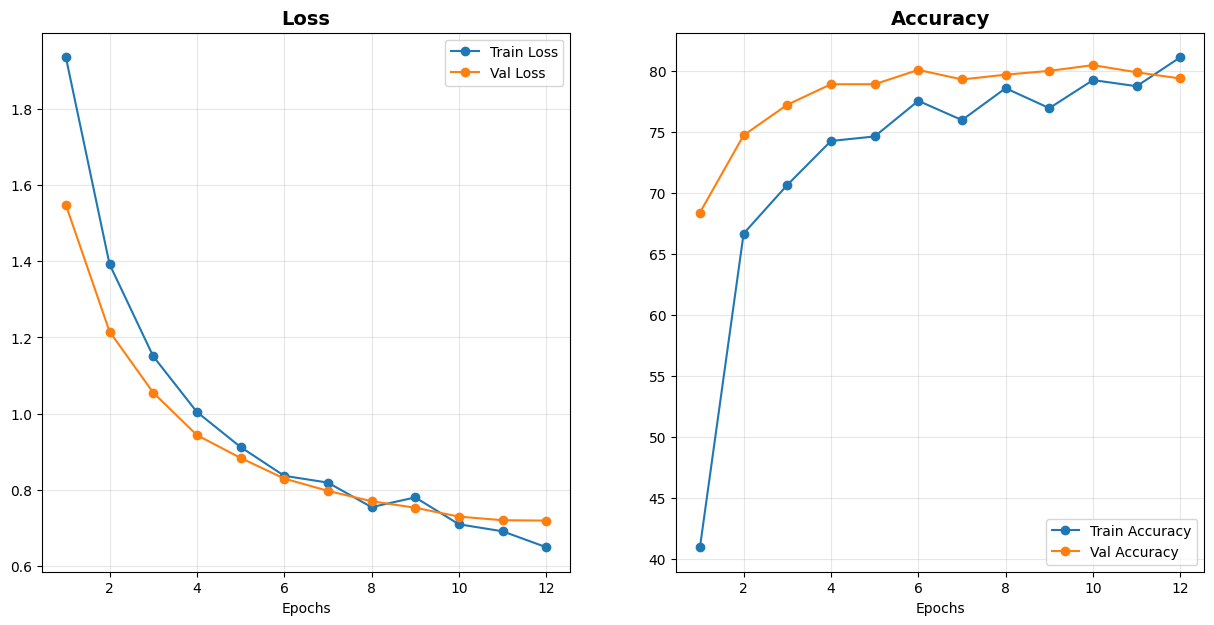

In [15]:
plot_loss_curves(efficientb2_transfer_learning_training_results,
                 save_path="../figures/efficientb2_transfer_learning.png")

### Results Comparison

Comparison figure saved to ../figures/model_comparison.png


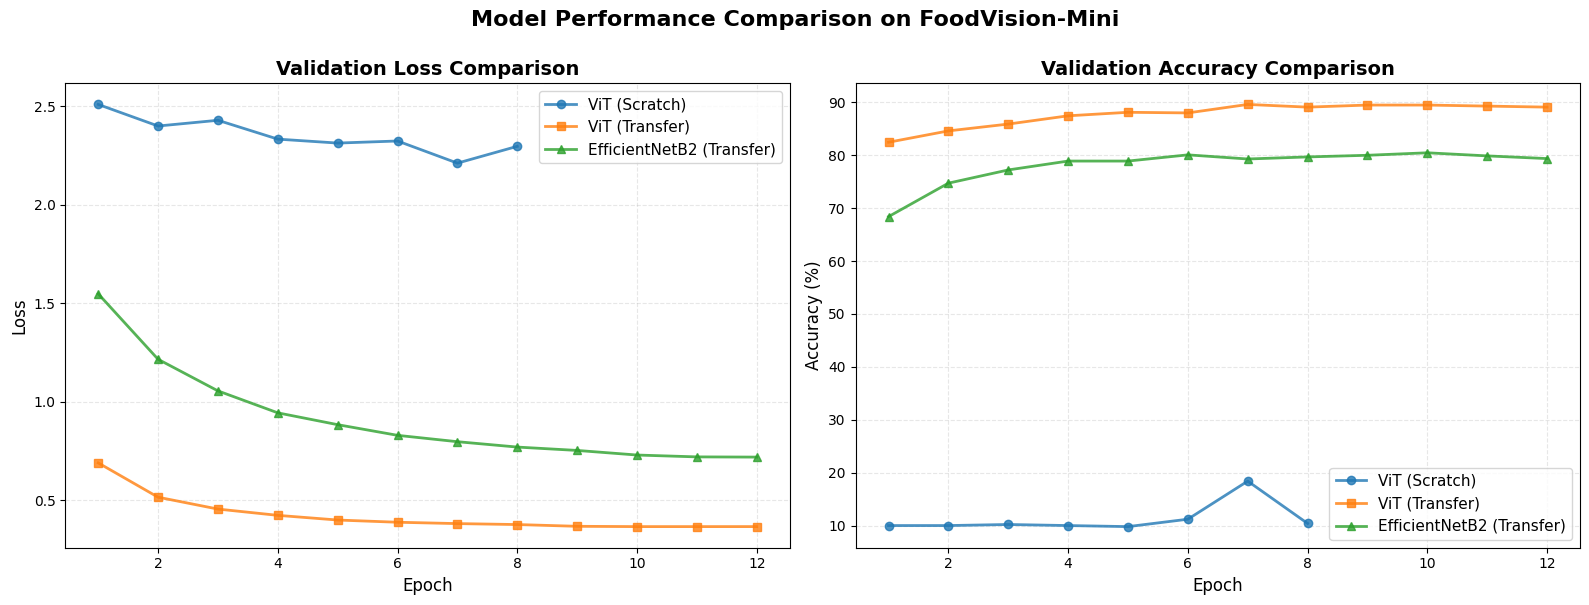

In [26]:
# Combined visualization
plot_model_comparison(
    results_dict={
        "ViT (Scratch)": vit_training_from_scratch_results,
        "ViT (Transfer)": vit_transfer_learning_training_results,
        "EfficientNetB2 (Transfer)" : efficientb2_transfer_learning_training_results
    },
    save_path="../figures/model_comparison.png"
)

### Comparison Table

In [ ]:
# Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Function to get model size in MB
def get_model_size_mb(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    return (param_size + buffer_size) / 1024**2

# Function to get metrics from best validation loss epoch
def get_best_metrics(results):
    best_epoch_idx = results['val_loss'].index(min(results['val_loss']))
    return {
        'val_acc': results['val_acc'][best_epoch_idx],
        'val_loss': results['val_loss'][best_epoch_idx],
        'epoch': best_epoch_idx + 1 
    }

# Get best metrics for each model
vit_scratch_best = get_best_metrics(vit_training_from_scratch_results)
vit_transfer_best = get_best_metrics(vit_transfer_learning_training_results)
effnet_best = get_best_metrics(efficientb2_transfer_learning_training_results)

# Get model sizes
vit_scratch_params = count_parameters(vit_from_scratch) / 1e6
vit_transfer_params = count_parameters(vit_transfer_learning) / 1e6
effnet_params = count_parameters(efficient_b2_model) / 1e6

vit_scratch_size = get_model_size_mb(vit_from_scratch)
vit_transfer_size = get_model_size_mb(vit_transfer_learning)
effnet_size = get_model_size_mb(efficient_b2_model)

# Create comparison DataFrame
results_comparison = pd.DataFrame({
    'Model': ['ViT (Scratch)', 'ViT (Transfer)', 'EfficientNet-B2 (Transfer)' ],
    'Params (M)': [
        round(vit_scratch_params, 2),
        round(vit_transfer_params, 2),
        round(effnet_params, 2)
    ],
    'Size (MB)': [
        round(vit_scratch_size, 2),
        round(vit_transfer_size, 2),
        round(effnet_size, 2)
    ],
    'Val Acc (%)': [
        round(vit_scratch_best['val_acc'], 2),
        round(vit_transfer_best['val_acc'], 2),
        round(effnet_best['val_acc'], 2)
    ],
    'Val Loss': [
        round(vit_scratch_best['val_loss'], 4),
        round(vit_transfer_best['val_loss'], 4),
        round(effnet_best['val_loss'], 4)
    ],
    'Best Epoch': [
        vit_scratch_best['epoch'],
        vit_transfer_best['epoch'],
        effnet_best['epoch']
    ],
    'Training Time (m)': [
        12,
        8,
        2
    ]
})

# Display in notebook
display(results_comparison)

,Model,Params (M),Size (MB),Val Acc (%),Val Loss,Best Epoch,Training Time (m)
0,ViT (Scratch),85.81,327.33,18.40,2.2108,7,12
1,ViT (Transfer),85.81,327.33,89.49,0.3665,10,8
2,EfficientNet-B2 (Transfer),7.72,29.69,79.38,0.7192,12,2
